In [ ]:
#import libraries
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0

    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)

    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

In [ ]:
corpuss = [
    'I like deep learning',
    'I enjoy natural language processing',
    'I prefer Python over Java',
    'Machine learning is fascinating',
]
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(corpuss)

#### Word_to_index: A dictionary mapping each word to an integer value

In [ ]:
word_to_index

{'i': 0,
 'like': 1,
 'deep': 2,
 'learning': 3,
 'enjoy': 4,
 'natural': 5,
 'language': 6,
 'processing': 7,
 'prefer': 8,
 'python': 9,
 'over': 10,
 'java': 11,
 'machine': 12,
 'is': 13,
 'fascinating': 14}

#### Index_to_Word: A dictionary mapping each integer value to a word

In [ ]:
index_to_word

{0: 'i',
 1: 'like',
 2: 'deep',
 3: 'learning',
 4: 'enjoy',
 5: 'natural',
 6: 'language',
 7: 'processing',
 8: 'prefer',
 9: 'python',
 10: 'over',
 11: 'java',
 12: 'machine',
 13: 'is',
 14: 'fascinating'}

Vocab_Size:  Number of unique words in the corpus.

In [ ]:
vocab_size

15

Corpus: Given text consisting of all the words

In [ ]:
length_of_corpus

18

In [ ]:
###########################################################################################################################################################################

#### Function to generate context-target pairs


In [ ]:
def generate_context_target_pairs(corpus, window_size):
    pairs = []
    con=[]
    tar=[]
    for sentence in corpus:
        tokens = sentence.split()
        for i in range(len(tokens)):
            target = tokens[i]
            context = [tokens[j] for j in range(i - window_size, i + window_size + 1) if i != j and j >= 0 and j < len(tokens)]
            pairs.append((context, target))
            con.append(context)
            tar.append(target)
    return pairs, con, tar

In [ ]:
corpus = [
    'I like deep learning',
    'I enjoy natural language processing',
    'I prefer Python over Java',
    'Machine learning is fascinating',
]
context_target_pairs, X, targets = generate_context_target_pairs(corpus, window_size=2)

In [ ]:
print(context_target_pairs)

[(['like', 'deep'], 'I'), (['I', 'deep', 'learning'], 'like'), (['I', 'like', 'learning'], 'deep'), (['like', 'deep'], 'learning'), (['enjoy', 'natural'], 'I'), (['I', 'natural', 'language'], 'enjoy'), (['I', 'enjoy', 'language', 'processing'], 'natural'), (['enjoy', 'natural', 'processing'], 'language'), (['natural', 'language'], 'processing'), (['prefer', 'Python'], 'I'), (['I', 'Python', 'over'], 'prefer'), (['I', 'prefer', 'over', 'Java'], 'Python'), (['prefer', 'Python', 'Java'], 'over'), (['Python', 'over'], 'Java'), (['learning', 'is'], 'Machine'), (['Machine', 'is', 'fascinating'], 'learning'), (['Machine', 'learning', 'fascinating'], 'is'), (['learning', 'is'], 'fascinating')]


In [ ]:
X

[['like', 'deep'],
 ['I', 'deep', 'learning'],
 ['I', 'like', 'learning'],
 ['like', 'deep'],
 ['enjoy', 'natural'],
 ['I', 'natural', 'language'],
 ['I', 'enjoy', 'language', 'processing'],
 ['enjoy', 'natural', 'processing'],
 ['natural', 'language'],
 ['prefer', 'Python'],
 ['I', 'Python', 'over'],
 ['I', 'prefer', 'over', 'Java'],
 ['prefer', 'Python', 'Java'],
 ['Python', 'over'],
 ['learning', 'is'],
 ['Machine', 'is', 'fascinating'],
 ['Machine', 'learning', 'fascinating'],
 ['learning', 'is']]

In [ ]:
targets

['I',
 'like',
 'deep',
 'learning',
 'I',
 'enjoy',
 'natural',
 'language',
 'processing',
 'I',
 'prefer',
 'Python',
 'over',
 'Java',
 'Machine',
 'learning',
 'is',
 'fascinating']

In [ ]:
# Tokenize and create vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_indexv1 = tokenizer.word_index
vocab_sizev1 = len(word_indexv1) + 1

Create Training data

In [ ]:
context_window = 2
def generate_data(corpus, context_window, tokenizer):
    sequences = tokenizer.texts_to_sequences(corpus)
    X, y = [], []
    for sequence in sequences:
        for i in range(context_window, len(sequence) - context_window):
            context = sequence[i - context_window : i] + sequence[i + 1 : i + context_window + 1]
            target = sequence[i]
            X.append(context)
            y.append(target)
    return np.array(X), np.array(y)

X_train, y_train = generate_data(corpus, context_window, tokenizer)

#### Set the model parameters

Reference: https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/5-NLP/15-LanguageModeling/CBoW-TF.ipynb


CBoW learns to predict a word based on the
 neighboring words. For example, when
, we will get the following pairs from the sentence I like to train networks: (like,I), (I, like), (to, like), (like,to), (train,to), (to, train), (networks, train), (train,networks). Here, first word is the neighboring word used as an input, and second word is the one we are predicting.

To build a network to predict next word, we will need to supply neighboring word as input, and get word number as output. The architecture of CBoW network is the following:

Input word is passed through the embedding layer. This very embedding layer would be our Word2Vec embedding, thus we will define it separately as embedder variable. We will use embedding size = 30 in this example, even though you might want to experiment with higher dimensions (real word2vec has 300)
Embedding vector would then be passed to a dense layer that will predict output word. Thus it has the vocab_size neurons.
Embedding layer in Keras automatically knows how to convert numeric input into one-hot encoding, so that we do not have to one-hot-encode input word separately. We specify input_length=1 to indicate that we want just one word in the input sequence - normally embedding layer is designed to work with longer sequences.

For the output, if we use sparse_categorical_crossentropy as loss function, we would also have to provide just word numbers as expected results, without one-hot encoding.

In [ ]:
embedding_dim = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=context_window*2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

#### Compile the model

In [ ]:
epochs = 50
batch_size = 16
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

In [ ]:
model.save_weights('cbow_weights.h5')
# Load the pre-trained weights
model.load_weights('cbow_weights.h5')

#### Visualize

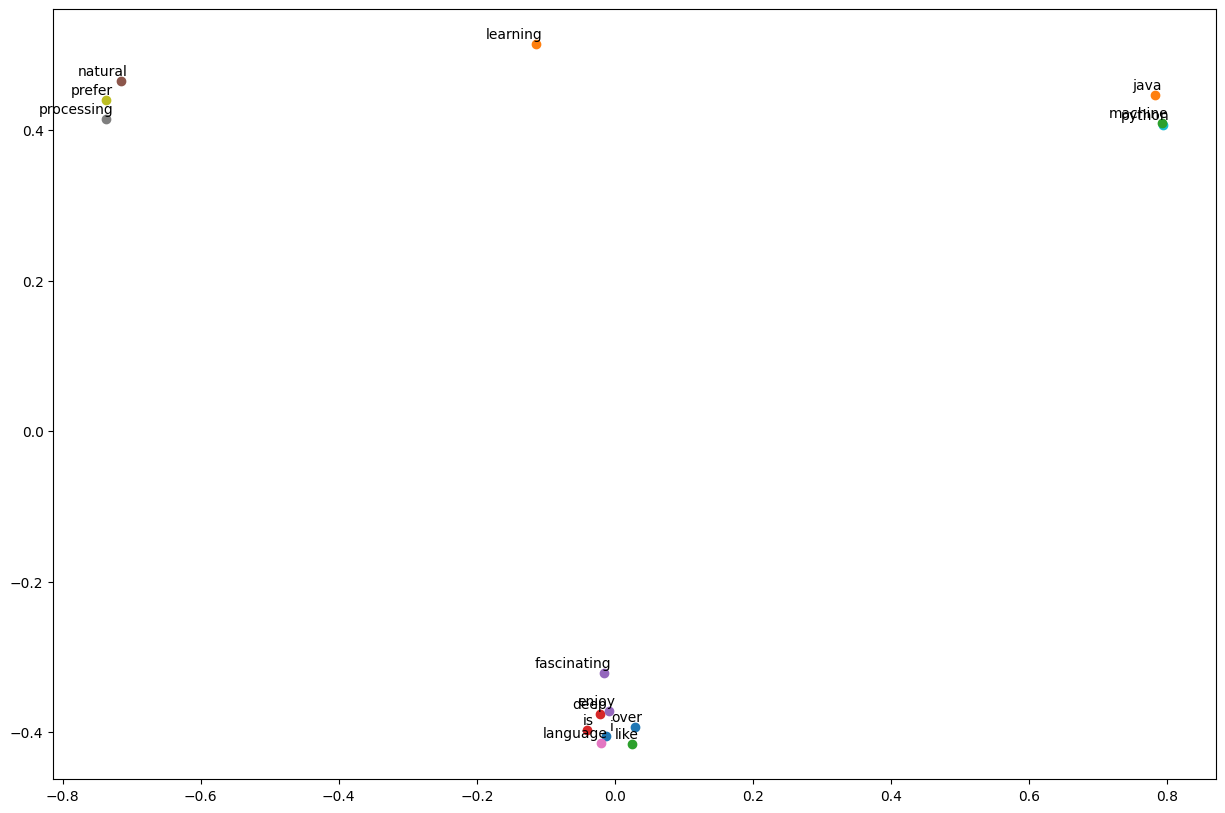

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

embeddings = model.get_weights()[0]

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(15, 10))
for i, word in enumerate(tokenizer.word_index.keys()):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',
                 ha='right', va='bottom')
plt.show()